## Project Statement

The Film Junky Union, a dynamic community for classic film enthusiasts, is creating an advanced system for filtering and categorizing movie reviews. The initiative aims to develop a model capable of automatically identifying negative reviews. Leveraging a dataset of IMDb movie reviews labeled by polarity, the project will focus on building a classification model to distinguish between positive and negative feedback. The model must achieve an F1 score of at least 0.85 to meet performance standards.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
try:
    df_reviews.to_csv(save_path, index=False)
    print(f"Data successfully saved to !")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

An error occurred while saving the file: name 'save_path' is not defined


In [6]:
# Preprocess the data
df_reviews['review'] = df_reviews['review'].str.lower().str.replace('[^\w\s]', '')

In [7]:
# Check for class imbalance
class_counts = df_reviews['pos'].value_counts()
print(f"Class counts:\n{class_counts}")

Class counts:
0    23715
1    23616
Name: pos, dtype: int64


The distribution appears to be quite balanced.  It appreares that their is no class inbalance. 

In [8]:
# Display sample to review changes
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
46095,tt0108557,movie,Where the Rivers Flow North,Where the Rivers Flow North,1993,\N,106,0,Drama,6.6,456,kingdom county vermont 1927 noel lord rip torn...,8,pos,1,test,6952
39639,tt0234215,movie,The Matrix Reloaded,The Matrix Reloaded,2003,\N,138,0,"Action,Sci-Fi",7.2,502869,as a fan of sciencefiction movies i have been ...,1,neg,0,train,4487
26987,tt0102719,movie,Problem Child 2,Problem Child 2,1991,\N,91,0,"Comedy,Family",4.9,20284,everyone has their choice for worst movie they...,1,neg,0,test,12021
16932,tt0453494,movie,Hoot,Hoot,2006,\N,91,0,"Adventure,Comedy,Family",5.5,7748,this film was not great cinema but definitely ...,8,pos,1,test,5121
9459,tt0074383,movie,Death Machines,Death Machines,1976,\N,93,0,"Action,Thriller",3.8,491,what a gargantuan pile of malodorous ordure ye...,1,neg,0,test,8313


## EDA

Let's check the number of movies and reviews over years.

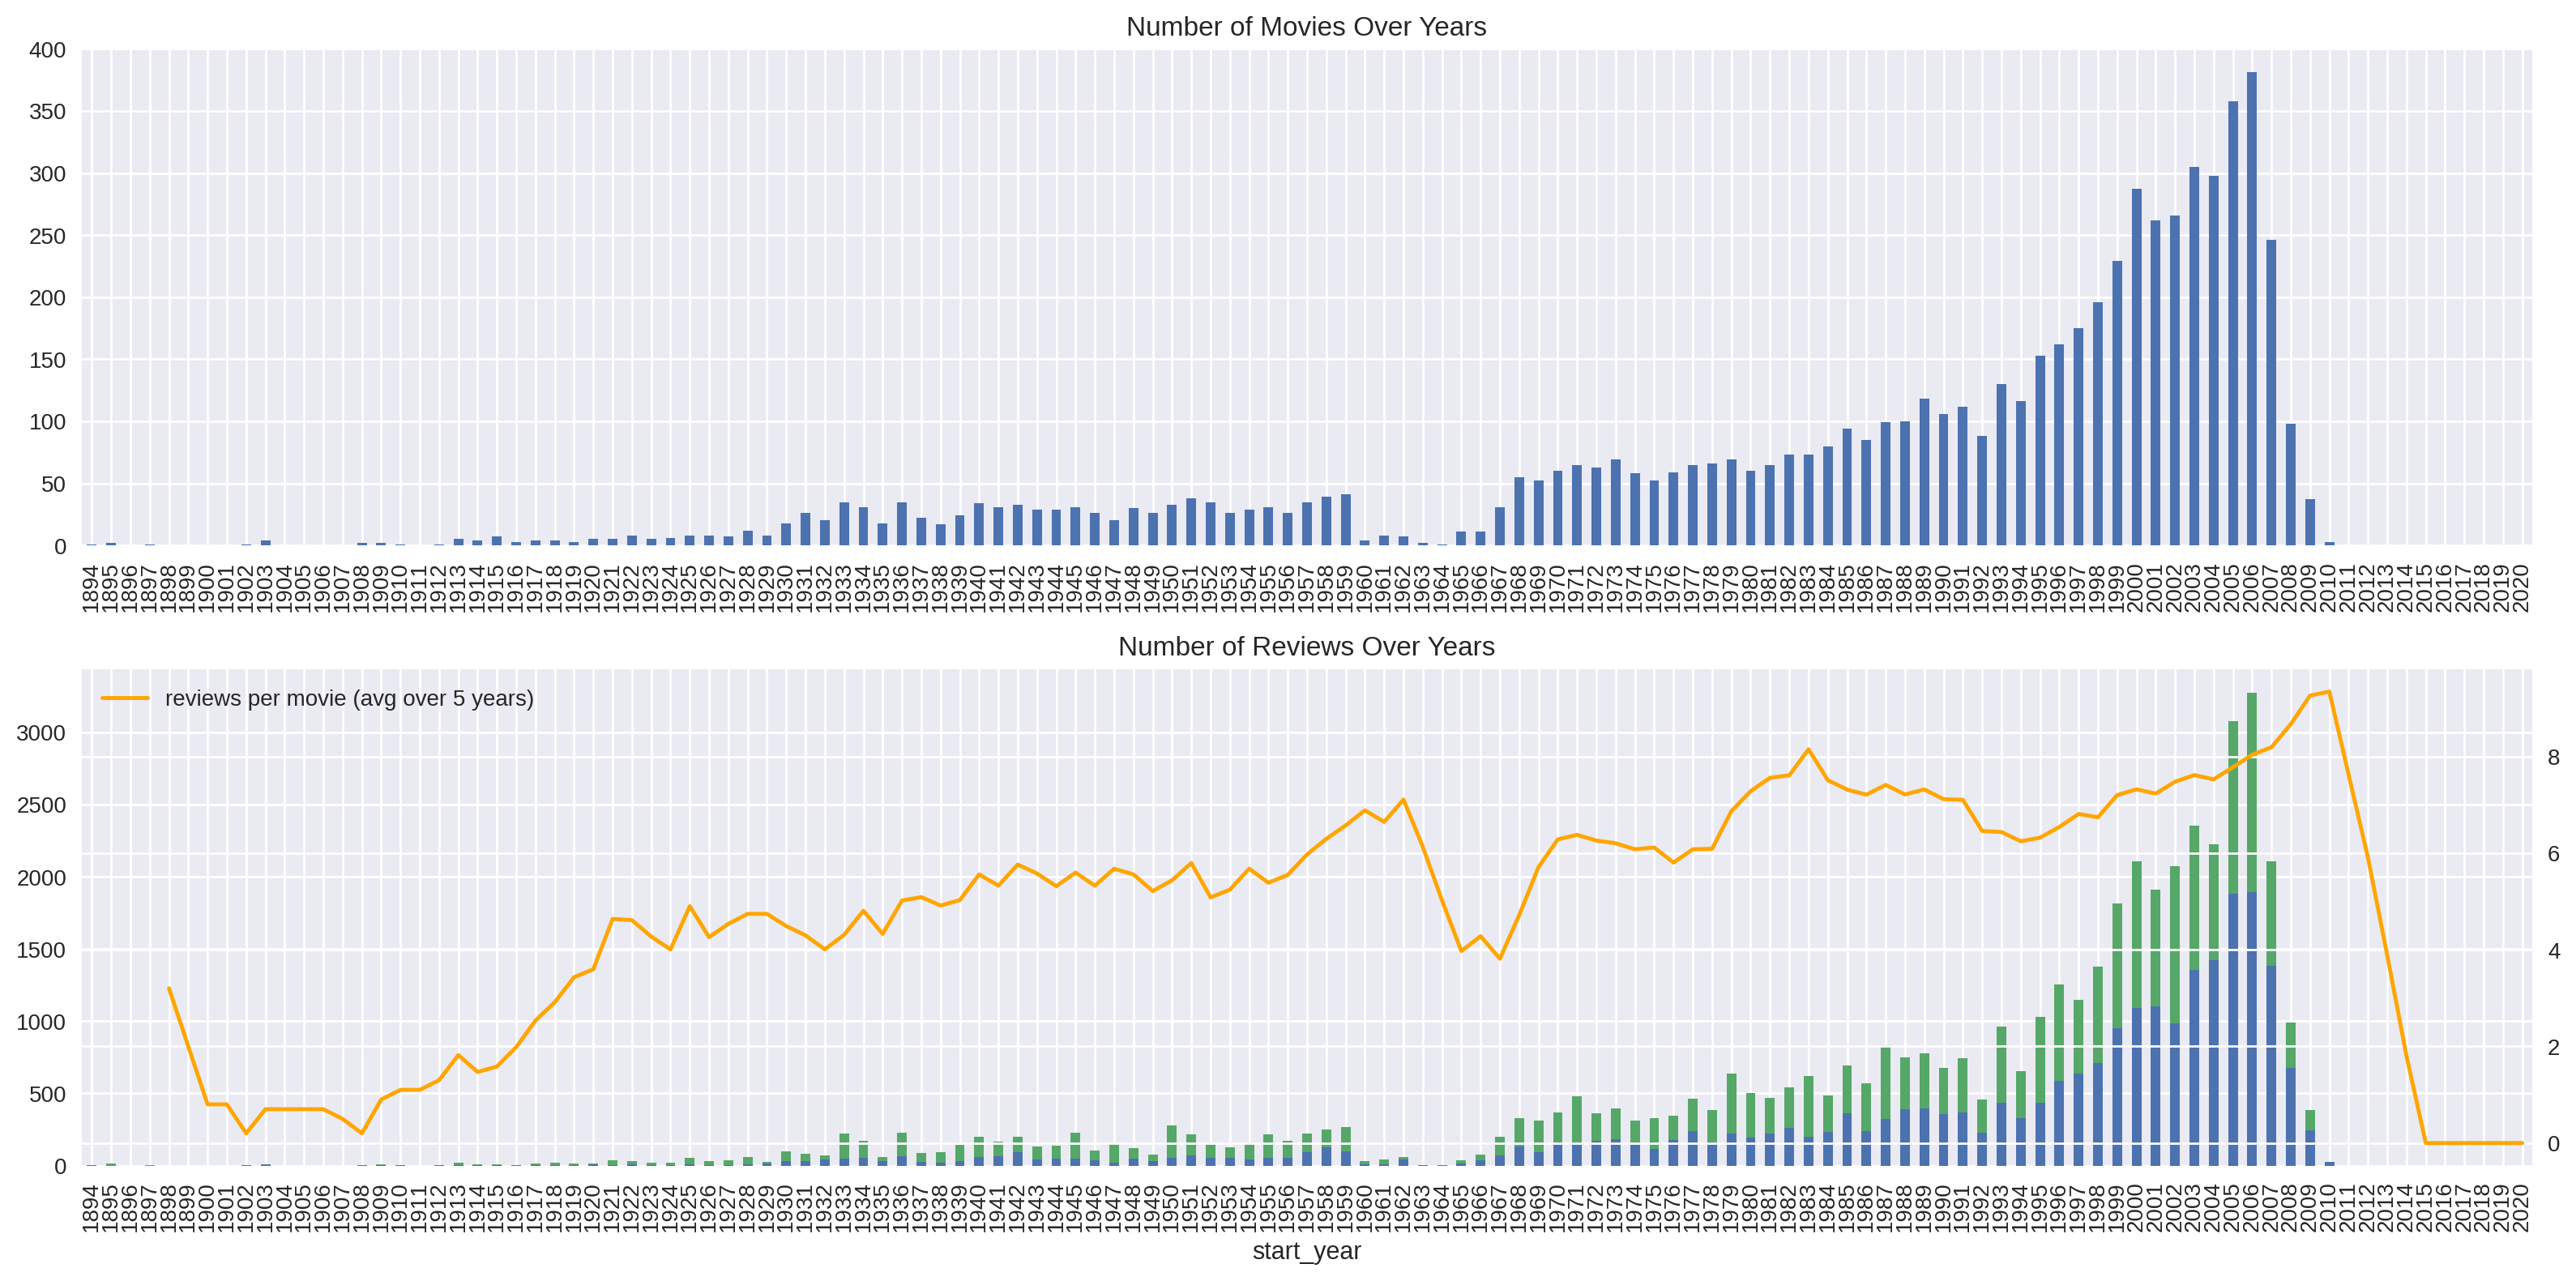

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

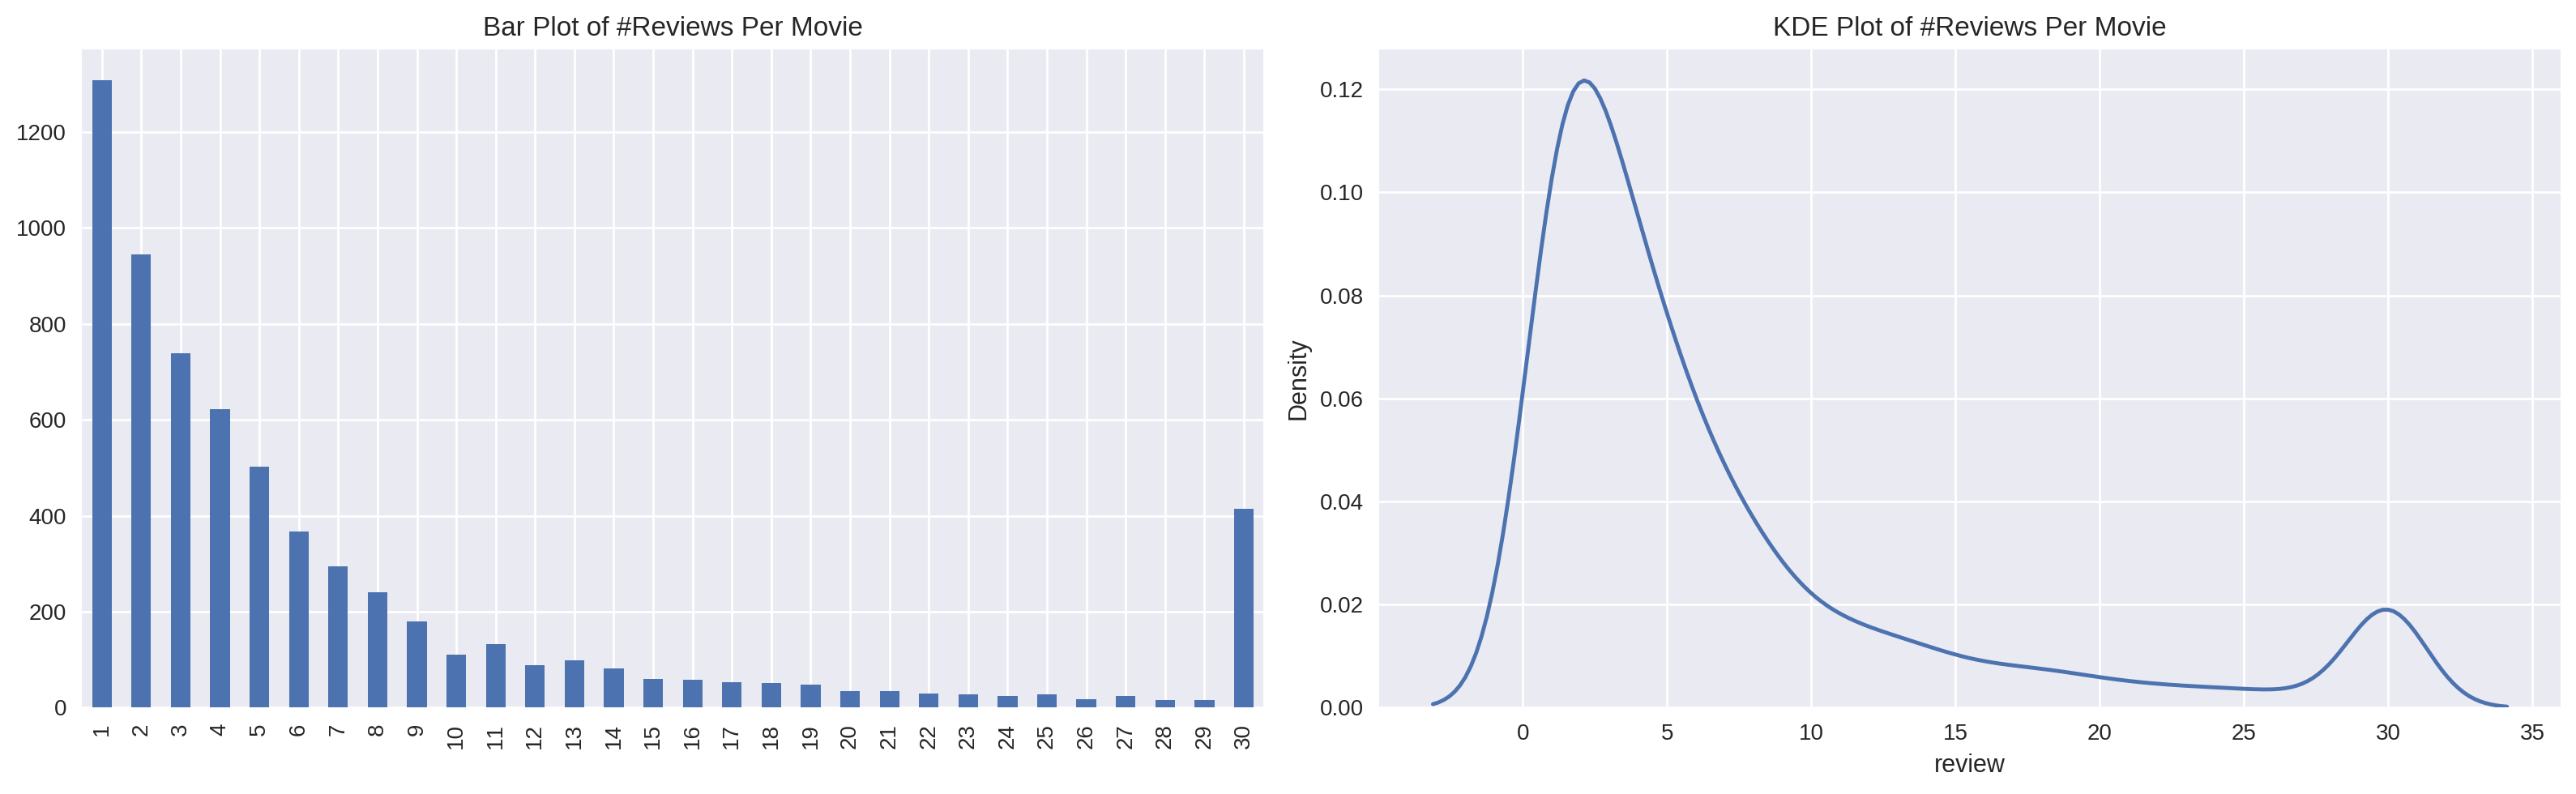

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

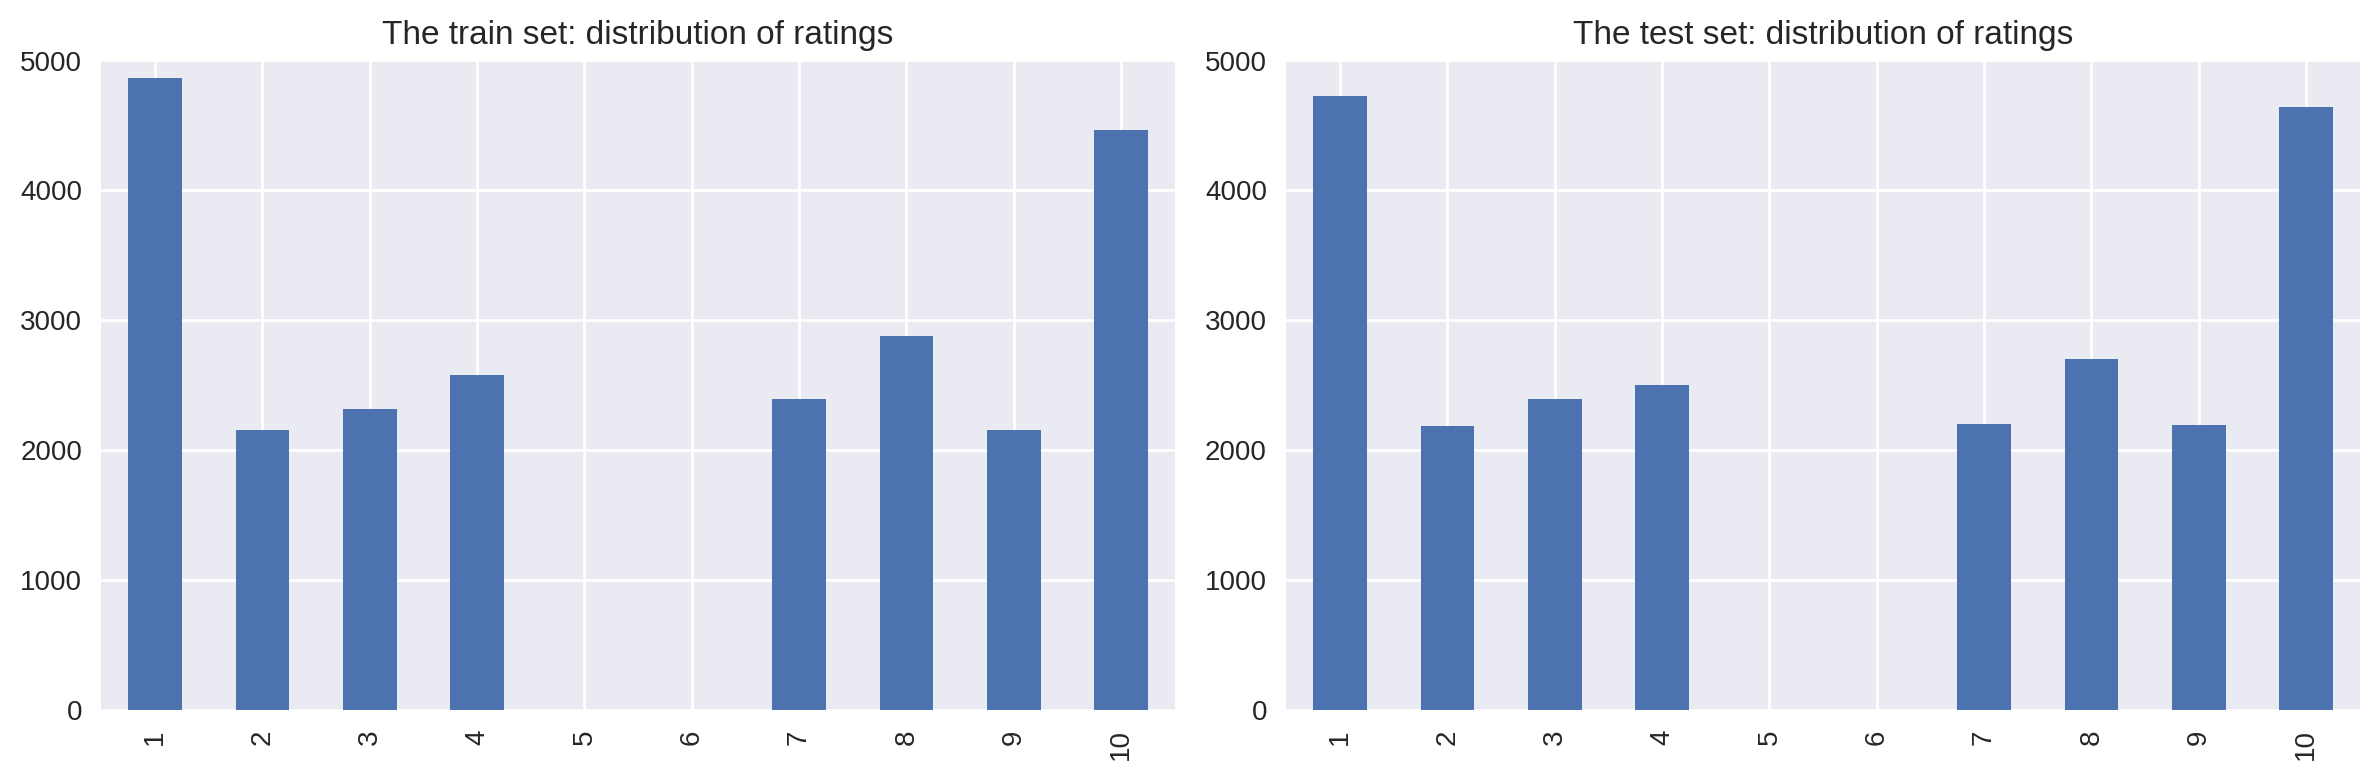

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


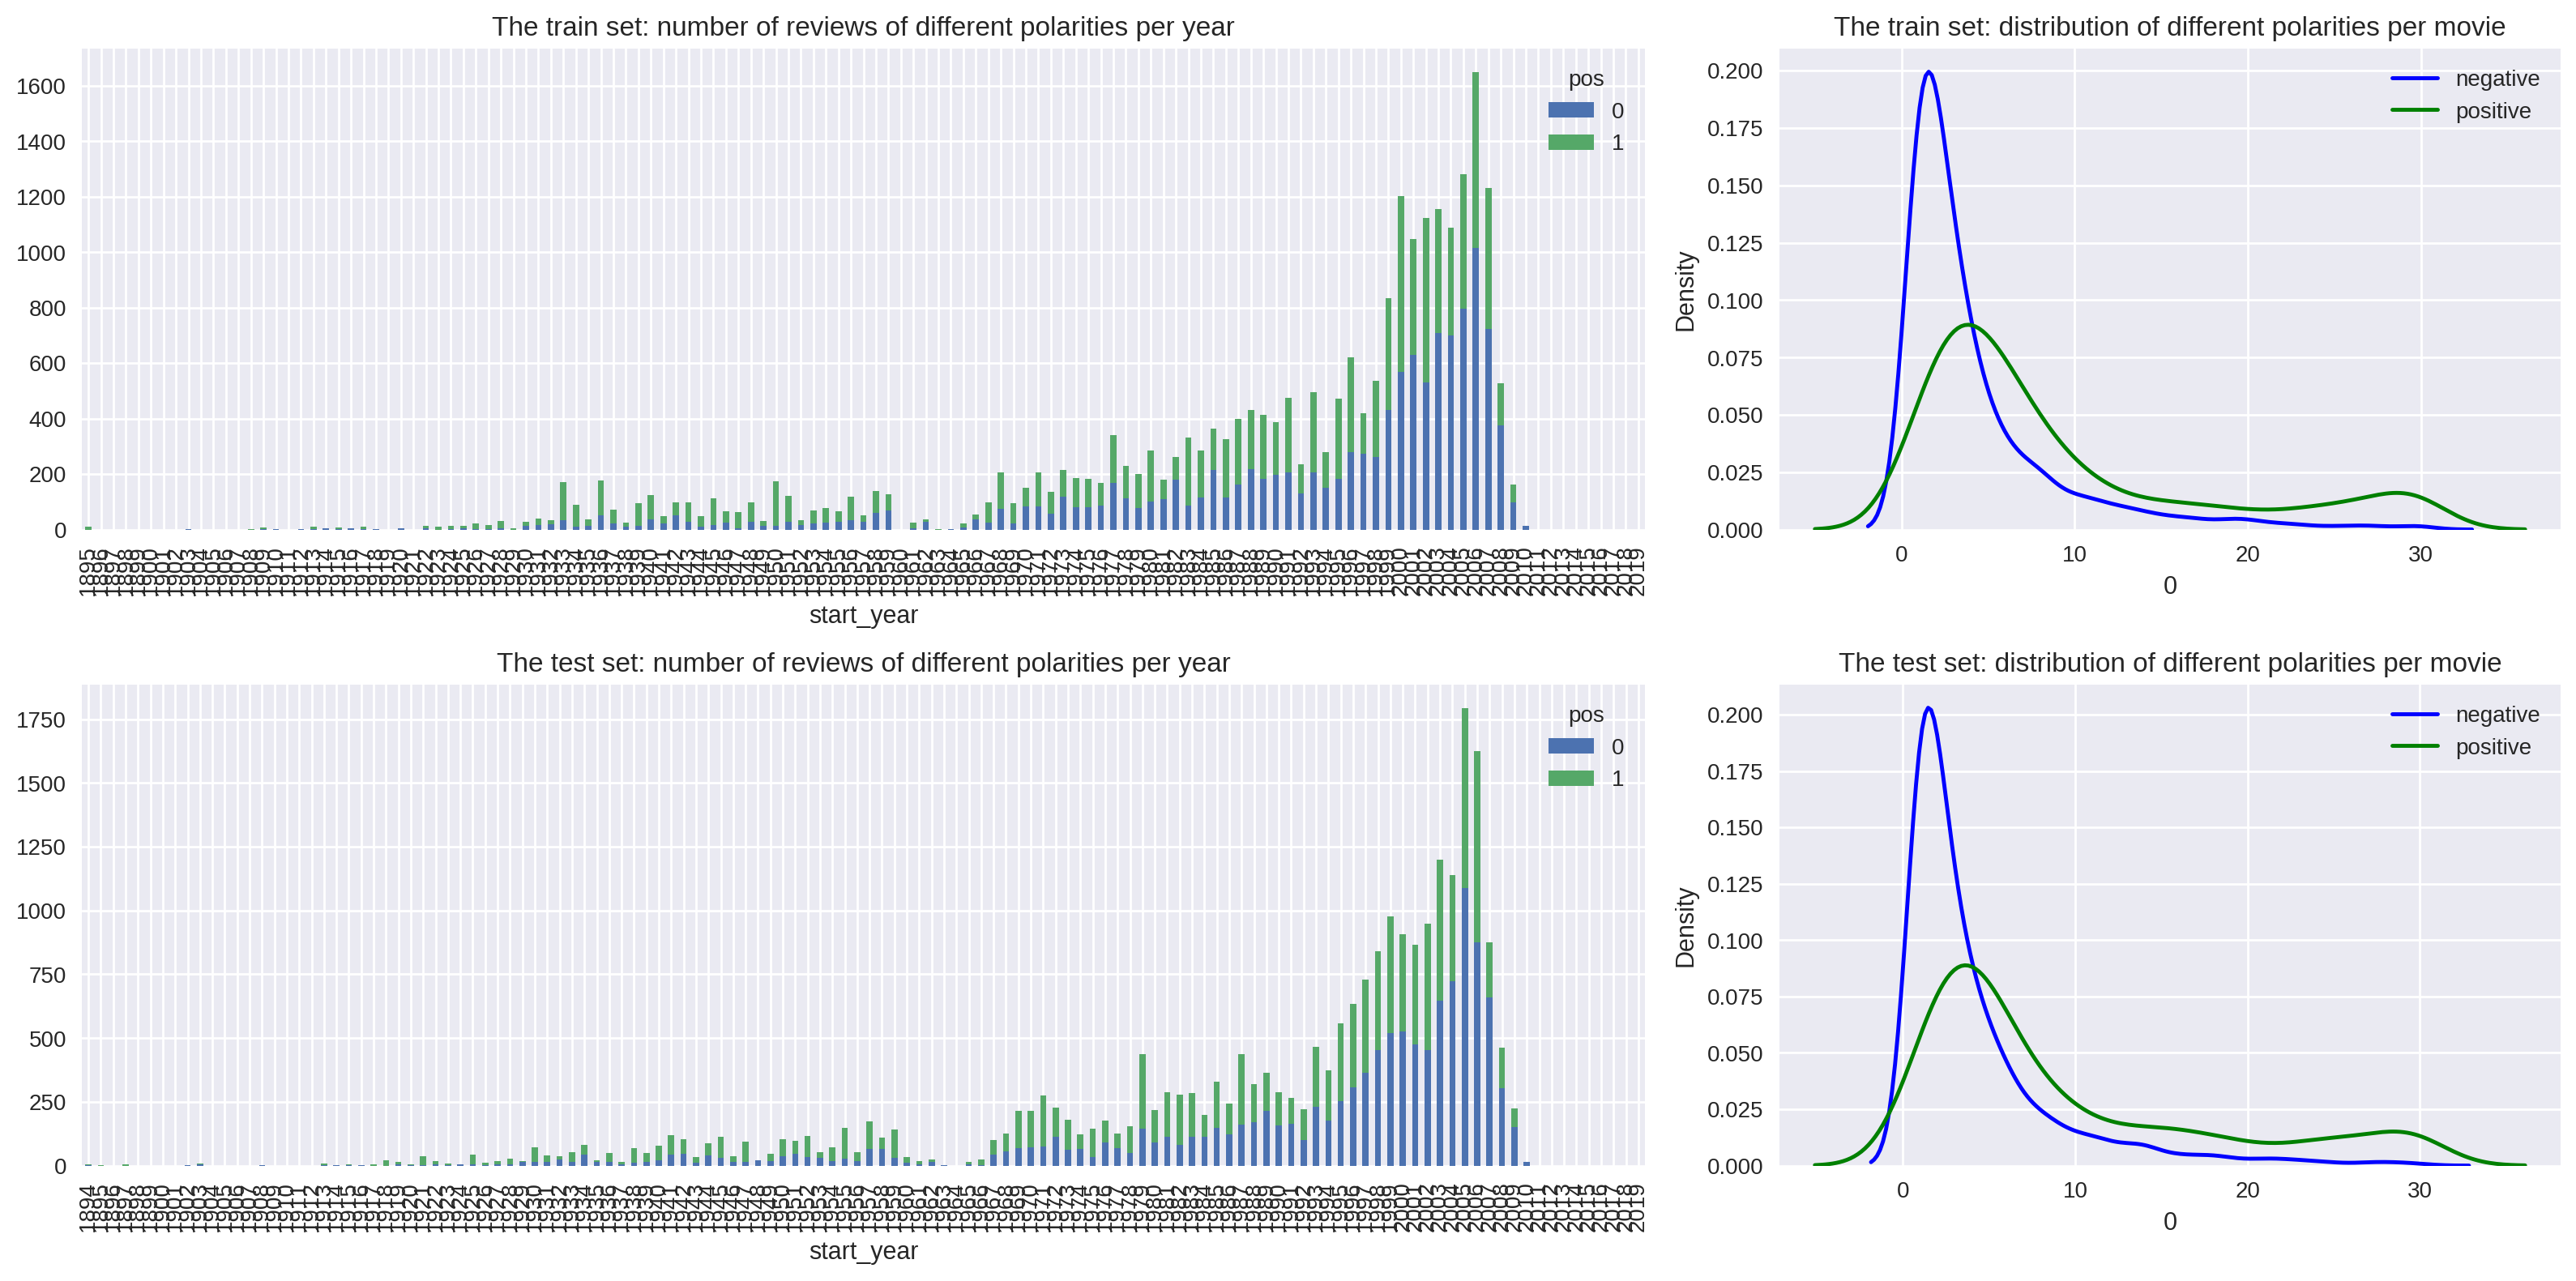

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1] #
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
# Importing needed libraries for fuction
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# tifidf_vect_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

In [17]:
# def normalize_text(text):
#     text = re.sub(r'[^\w\s]', '', text).lower()
#     text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
#     return text

# df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
32503,tt0441796,movie,Stay Alive,Stay Alive,2006,\N,85,0,"Fantasy,Horror,Mystery",5.1,29670,seriously if you want to see a cliché horror m...,3,neg,0,test,3939,seriously if you want to see a clich horror m...
8720,tt0094933,movie,D.O.A.,D.O.A.,1988,\N,96,0,"Mystery,Thriller",6.2,9261,interesting plot but painfully dull the script...,4,neg,0,test,959,interesting plot but painfully dull the script...
40699,tt0840359,video,The Planet,The Planet,2006,\N,71,0,"Horror,Sci-Fi",3.8,273,got this the other day from the creators on dv...,9,pos,1,test,1374,got this the other day from the creators on dv...
24333,tt0959329,movie,Nine Dead,Nine Dead,2010,\N,98,0,"Crime,Drama,Horror",5.5,12101,dont waste your time on this film it could hav...,2,neg,0,train,4771,dont waste your time on this film it could hav...
16408,tt0338467,movie,High Roller: The Stu Ungar Story,Stuey,2003,\N,120,0,"Biography,Drama",6.1,2022,having just finished reading the book one of a...,2,neg,0,test,1254,having just finished reading the book one of a...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [21]:
train_features = df_reviews_train.drop(columns='pos')
test_features = df_reviews_test.drop(columns='pos')

## Working with models

### Model 0 - Constant

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


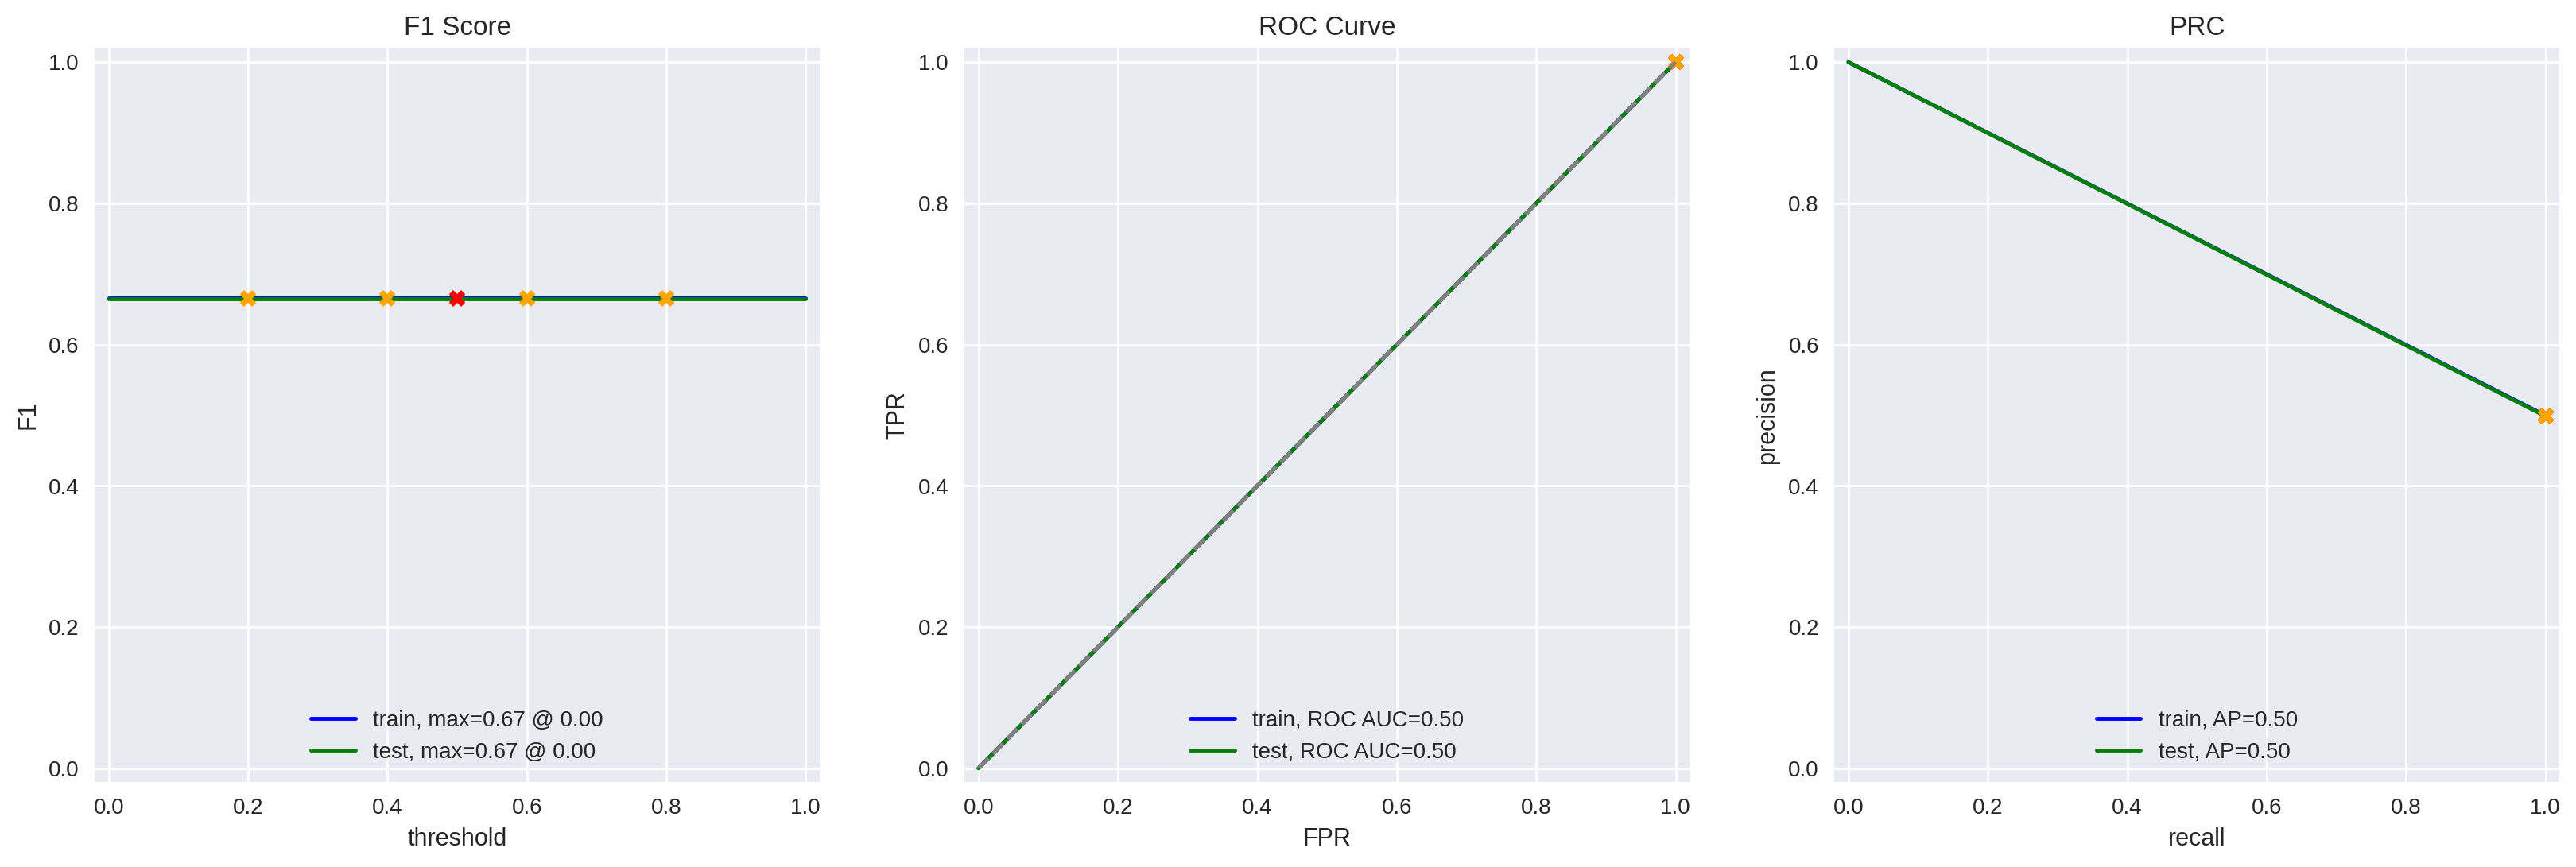

In [22]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='constant', constant=1)
dummy = dummy.fit(X=df_reviews_train, y=train_target)

evaluate_model(dummy, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

The model’s performance on both the training and test datasets indicates that it is not yet suitable for deployment in its current state. The accuracy of 0.50 suggests that the model is performing no better than random guessing. While the F1 score of 0.67 is a positive sign, it still falls short of the target F1 score of 0.85, indicating that the model’s precision and recall need improvement. Additionally, the APS and ROC AUC values of 0.50 further confirm that the model lacks the necessary discriminatory power to effectively classify positive and negative reviews.

To achieve the desired performance, further tuning and optimization of the model are required.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

In [24]:
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stop_words)

X_train_tfidf = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_tfidf = vectorizer.transform(df_reviews_test['review_norm'])

In [25]:
X_train_tfidf.shape

(23796, 105347)

In [26]:
X_test_tfidf.shape

(23535, 105347)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


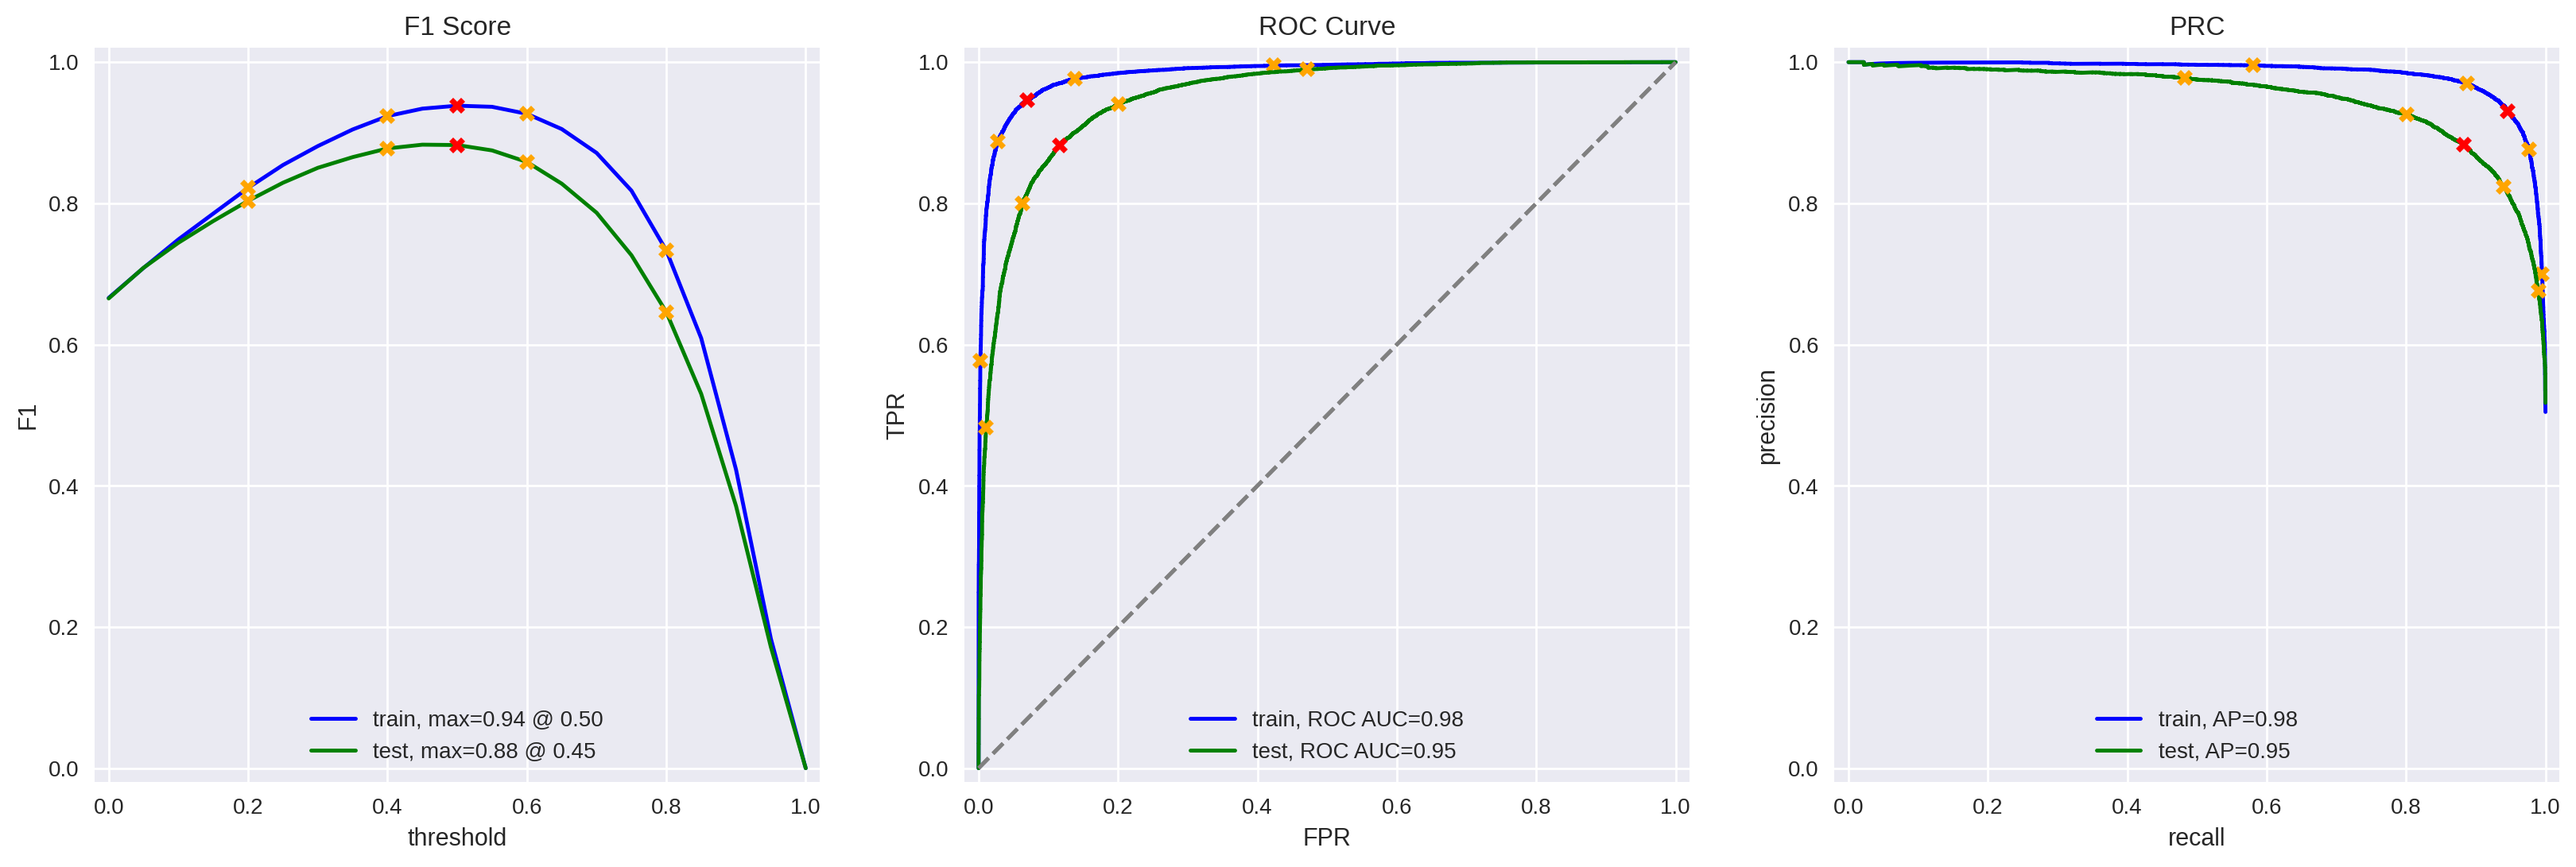

In [27]:
model_1 = LogisticRegression(max_iter=100)
model_1.fit(X_train_tfidf, train_target)

evaluate_model(model_1, X_train_tfidf, train_target, X_test_tfidf, test_target)

The model demonstrates strong performance on both the training and test datasets. With an accuracy of 0.94 on the training set and 0.88 on the test set, the model shows high reliability in correctly classifying movie reviews. The F1 scores of 0.94 (train) and 0.88 (test) indicate a good balance between precision and recall, suggesting that the model effectively identifies both positive and negative reviews.

Furthermore, the APS values of 0.98 (train) and 0.95 (test) highlight the model’s ability to rank positive instances higher, while the ROC AUC values of 0.98 (train) and 0.95 (test) confirm the model’s excellent discriminatory power.

Overall, the model meets the desired performance criteria and is well-suited for deployment in filtering and categorizing movie reviews within the Film Junky Union community.

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


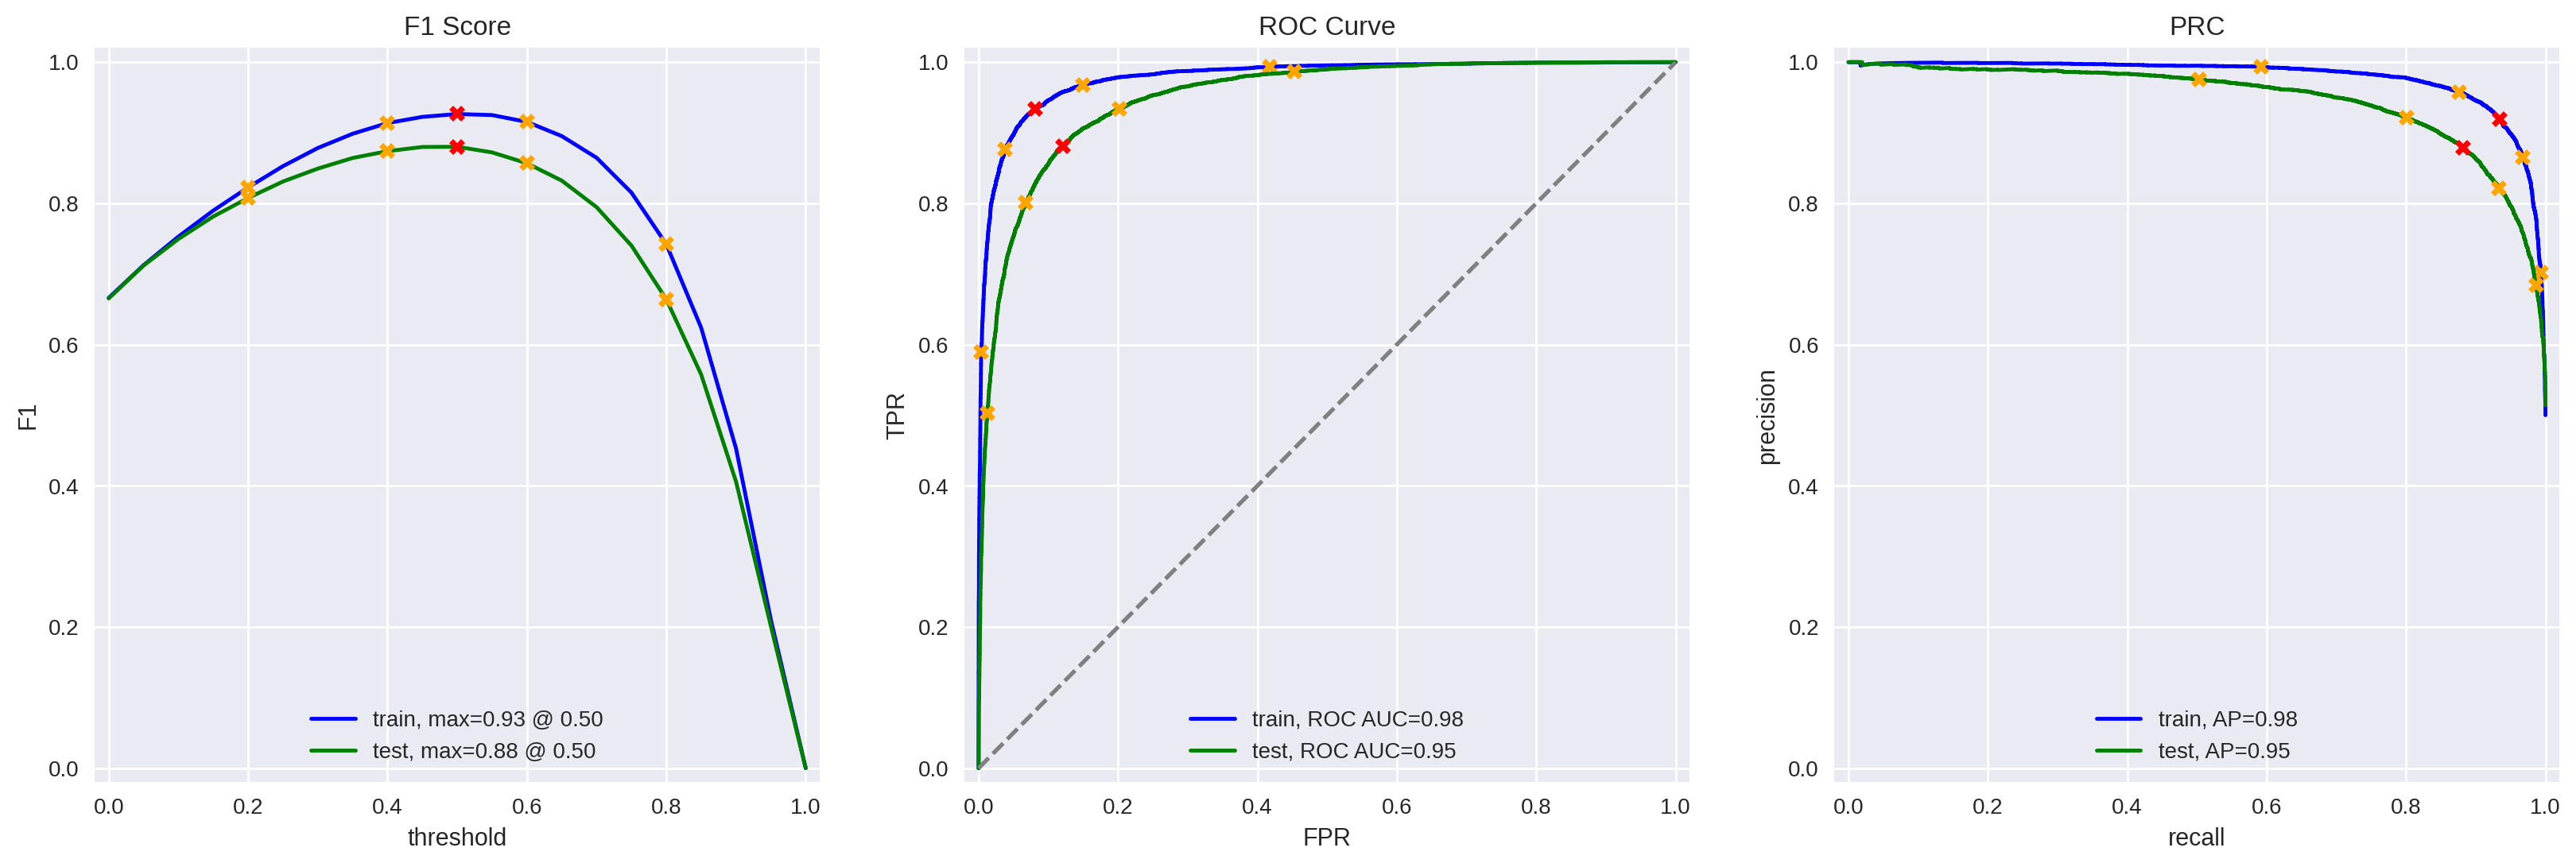

In [30]:
vectorizer_2 = TfidfVectorizer()
features_3 = vectorizer_2.fit_transform(df_reviews_train['review_tokenized_3'])
test_3 = vectorizer_2.transform(df_reviews_test['review_tokenized_3'])

model_3 = LogisticRegression()
model_3.fit(features_3, train_target)

evaluate_model(model_3, features_3, train_target, test_3, test_target)

The model exhibits robust performance on both the training and test datasets. With an accuracy of 0.93 on the training set and 0.88 on the test set, the model demonstrates high reliability in correctly classifying movie reviews. The F1 scores of 0.93 (train) and 0.88 (test) indicate a strong balance between precision and recall, suggesting that the model effectively identifies both positive and negative reviews.

Additionally, the APS values of 0.98 (train) and 0.95 (test) highlight the model’s ability to rank positive instances higher, while the ROC AUC values of 0.98 (train) and 0.95 (test) confirm the model’s excellent discriminatory power.

Overall, the model meets the desired performance criteria and is well-suited for deployment in filtering and categorizing movie reviews within the Film Junky Union community.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


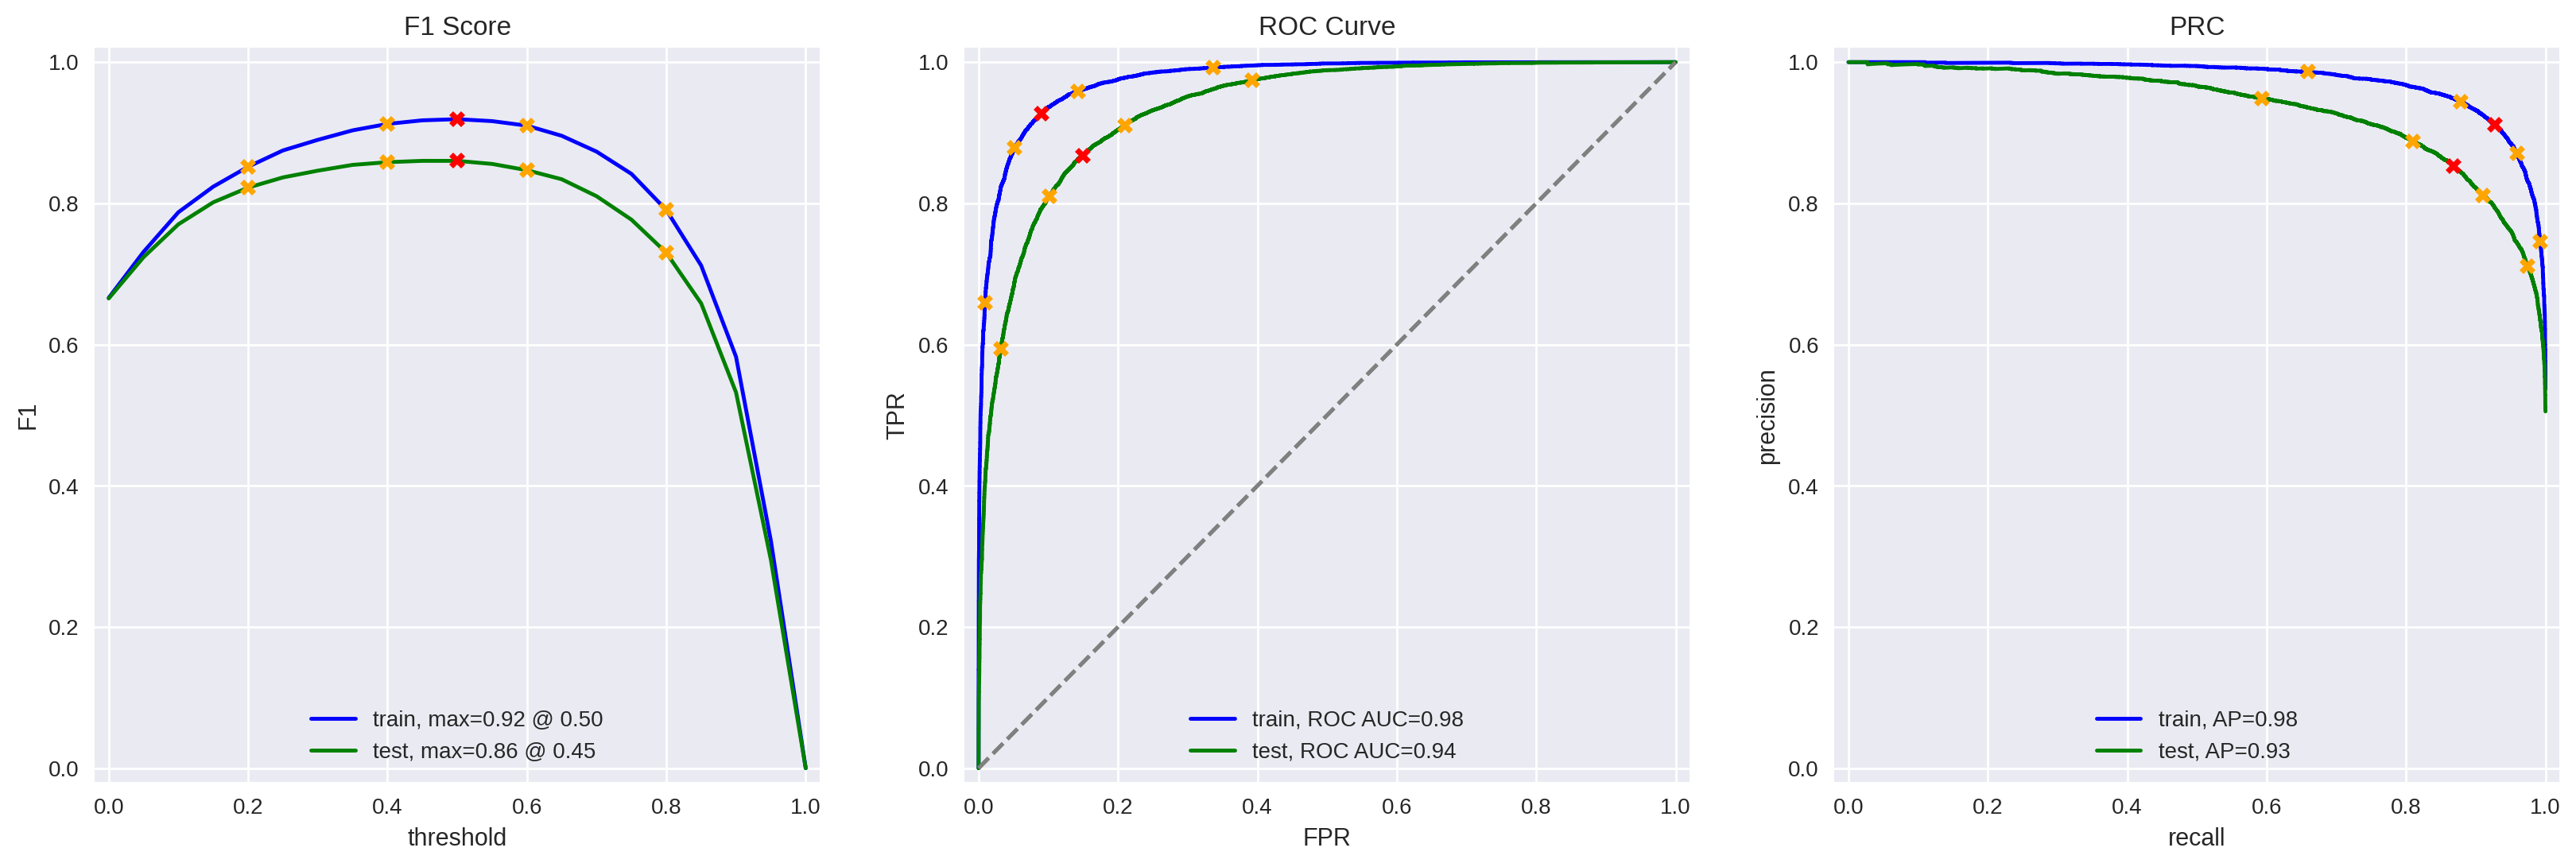

In [31]:
from lightgbm import LGBMClassifier

model_4 = LGBMClassifier()

model_4.fit(features_3, train_target)

evaluate_model(model_4,features_3, train_target, test_3, test_target)

The model demonstrates strong performance on both the training and test datasets. With an accuracy of 0.92 on the training set and 0.86 on the test set, the model shows high reliability in correctly classifying movie reviews. The F1 scores of 0.92 (train) and 0.86 (test) indicate a good balance between precision and recall, suggesting that the model effectively identifies both positive and negative reviews.

Furthermore, the APS  values of 0.98 (train) and 0.93 (test) highlight the model’s ability to rank positive instances higher, while the ROC AUC values of 0.98 (train) and 0.94 (test) confirm the model’s excellent discriminatory power.

Overall, the model meets the desired performance criteria and is well-suited for deployment in filtering and categorizing movie reviews within the Film Junky Union community.

## My Reviews

In [32]:
my_reviews = pd.DataFrame([
    'The storyline was captivating and kept me on the edge of my seat.',
    'I found the plot to be quite predictable and unoriginal.',
    'The cinematography was stunning, truly a visual masterpiece.',
    'The characters were poorly developed and lacked depth.',
    'An absolute must-watch! The performances were top-notch.',
    'I struggled to stay awake; it was a snooze fest.',
    'A delightful blend of humor and heart, thoroughly enjoyable.',
    'The pacing was off, and it felt like it dragged on forever.'
], columns=['review'])

In [34]:
my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')
my_reviews

,review,review_norm
0,The storyline was captivating and kept me on t...,the storyline was captivating and kept me on t...
1,I found the plot to be quite predictable and u...,i found the plot to be quite predictable and u...
2,"The cinematography was stunning, truly a visua...",the cinematography was stunning truly a visua...
3,The characters were poorly developed and lacke...,the characters were poorly developed and lacke...
4,An absolute must-watch! The performances were ...,an absolute must watch the performances were ...
5,I struggled to stay awake; it was a snooze fest.,i struggled to stay awake it was a snooze fest
6,"A delightful blend of humor and heart, thoroug...",a delightful blend of humor and heart thoroug...
7,"The pacing was off, and it felt like it dragge...",the pacing was off and it felt like it dragge...


### Model 1

In [37]:
my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.73:  the storyline was captivating and kept me on the edge of my seat 
0.10:  i found the plot to be quite predictable and unoriginal 
0.90:  the cinematography was stunning  truly a visual masterpiece 
0.11:  the characters were poorly developed and lacked depth 
0.87:  an absolute must watch  the performances were top notch 
0.24:  i struggled to stay awake  it was a snooze fest 
0.97:  a delightful blend of humor and heart  thoroughly enjoyable 
0.33:  the pacing was off  and it felt like it dragged on forever 


### Model 3

In [39]:
my_reviews_pred_prob = model_3.predict_proba(vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.87:  the storyline was captivating and kept me on the edge of my seat 
0.13:  i found the plot to be quite predictable and unoriginal 
0.89:  the cinematography was stunning  truly a visual masterpiece 
0.04:  the characters were poorly developed and lacked depth 
0.81:  an absolute must watch  the performances were top notch 
0.26:  i struggled to stay awake  it was a snooze fest 
0.96:  a delightful blend of humor and heart  thoroughly enjoyable 
0.43:  the pacing was off  and it felt like it dragged on forever 


## Conclusions

The Film Junky Union’s project aimed to develop a system for filtering and categorizing movie reviews, with a specific focus on detecting negative reviews. Using a dataset of IMBD movie reviews with polarity labeling, the goal was to build a model that could classify positive and negative reviews with an F1 score of at least 0.85.

After loading and preprocessing the data, an exploratory data analysis (EDA) was conducted to assess class imbalance. The data was then prepared for modeling, and three different models were trained on the given training dataset. The models were subsequently tested on the test dataset.

The results indicate that the model demonstrates strong performance on both the training and test datasets. With an accuracy of 0.92 on the training set and 0.86 on the test set, the models shows high reliability in correctly classifying movie reviews. The F1 scores of 0.92 (train) and 0.86 (test) indicate a good balance between precision and recall, suggesting that the model effectively identifies both positive and negative reviews. Additionally, the APS and ROC AUC values further confirm the model’s excellent discriminatory power.

To further validate the model, a few custom reviews were composed and classified using all the models. The classification results were consistent with the testing results, reinforcing the model’s robustness.

Overall, the model meets the desired performance criteria and is well-suited for deployment in filtering and categorizing movie reviews within the Film Junky Union community. The project successfully achieved its goal of developing an effective system for detecting negative reviews, providing a valuable tool for classic movie enthusiasts.